# Курсовой проект для курса "Python для Data Science"

Материалы к проекту (файлы):
* train.csv
* test.csv

#### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

#### Целевая переменная:
Price

#### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Содержание:

In [343]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
# Следующая магическая команда Jupyter Notebook нужна для того, чтобы графики
# отображались прямо в ноутбуке, а не в отдельном окне
%matplotlib inline

# Настройка более четкого отображения графиков
%config InlineBackend.figure_format = 'svg'

# Уберем warnings
import warnings
warnings.filterwarnings('ignore')

# Дата и время
from datetime import datetime

Загружаем данные

In [286]:
# Расположение данных
TEST_DATA = './test.csv'
TRAIN_DATA = './train.csv'

In [287]:
train_data = pd.read_csv(TRAIN_DATA, engine='python', on_bad_lines='skip')
train_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [288]:
train_data.shape

(10000, 20)

In [289]:
test_data = pd.read_csv(TEST_DATA, engine='python', on_bad_lines='skip')
test_data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [290]:
test_data.shape

(5000, 19)

Вывод: Тренировочный датасет содержит 10000 значений, тестовый - 5000

### Рассмотрим тренировочный датасет

In [291]:
# загрузим информацию о датасете
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Описание данных <a class='anchor' id='description'>
- Id - идентификационный номер квартиры;
- DistrictId - идентификационный номер района;
- Rooms - количество комнат;
- Square - площадь;
- LifeSquare - жилая площадь;
- KitchenSquare - площадь кухни;
- Floor - этаж;
- HouseFloor - количество этажей в доме;
- HouseYear - год постройки дома;
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности;
- Social_1, Social_2, Social_3 - социальные показатели местности;
- Healtcare_1, Heltcare_2 - показатели местности, связанные с охраной здоровья;
- Shops_1, Shops_2 - показатели связанные с наличием магазинов, торговых центров;
- Price - цена квартиры.

Уменьшим объем памяти, которую занимает датасет

In [292]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print(df.dtypes)
    
    return df

In [293]:
train_data = reduce_mem_usage(train_data)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object


In [294]:
# посмотрим статистику по датасету
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [295]:
# проверим датасет на дубликаты
duplicates = train_data.duplicated()
train_data[duplicates]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Вывод: дубликатов нет

Найдем пропущенные значения и заполним их

In [296]:
# найдем пропущенные значения
train_data.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Вывод: пропущенные значения есть в двух столбцах 'LifeSquare' и 'Healthcare_1'

##### **LifeSquare ** - жилая площадь

In [297]:
# создадим вспомогательный признак и заполним его 1, если пропуск есть
train_data['LifeSquare_nan'] = 0

In [298]:
train_data.loc[train_data['LifeSquare'].isna(), 'LifeSquare_nan']

7       0
8       0
21      0
23      0
25      0
       ..
9985    0
9986    0
9987    0
9994    0
9997    0
Name: LifeSquare_nan, Length: 2113, dtype: int64

In [299]:
train_data.loc[train_data['LifeSquare'].isna(), 'LifeSquare_nan'] = 1
train_data[train_data['LifeSquare_nan'] == 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
7,11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,221244.156250,1
8,5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,229102.796875,1
21,11935,27,2.0,64.711838,NaN,1.0,15,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,127200.023438,1
23,6641,54,3.0,118.907608,NaN,0.0,2,0.0,1977,0.006076,...,B,30,5285,0,645.0,6,6,B,571069.062500,1
25,5073,74,2.0,82.667915,NaN,1.0,16,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,244145.828125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,NaN,1.0,10,1.0,1977,0.211401,...,B,9,1892,0,NaN,0,1,B,95529.570312,1
9986,2996,1,2.0,64.994247,NaN,1.0,9,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,200332.515625,1
9987,15623,23,2.0,55.620090,NaN,0.0,2,4.0,1977,0.034656,...,B,0,168,0,NaN,0,0,B,115797.554688,1
9994,4158,23,2.0,64.864197,NaN,1.0,17,17.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,171323.515625,1


In [300]:
train_data['LifeSquare']

0       29.442751
1       40.049541
2       29.197611
3       52.731510
4       23.776169
          ...    
9995    30.476204
9996    20.539215
9997          NaN
9998    33.840149
9999    21.157875
Name: LifeSquare, Length: 10000, dtype: float32

In [301]:
train_data['LifeSquare'] = train_data['LifeSquare'].fillna(train_data['LifeSquare'].median())

##### 'Healthcare_1': 'показатели местности, связанные с охраной здоровья 1'

В этом столбце пропусков почти 50%. Такой признак может оказать существенное изменение на оценку модели, поэтому его можно удалить

In [302]:
train_data.drop('Healthcare_1', axis=1, inplace=True)

In [303]:
train_data.isna().sum()

Id                0
DistrictId        0
Rooms             0
Square            0
LifeSquare        0
KitchenSquare     0
Floor             0
HouseFloor        0
HouseYear         0
Ecology_1         0
Ecology_2         0
Ecology_3         0
Social_1          0
Social_2          0
Social_3          0
Helthcare_2       0
Shops_1           0
Shops_2           0
Price             0
LifeSquare_nan    0
dtype: int64

Вывод:  больше пропусков нет.

### Визуализируем признаки

Разделим признаки на численные и строковые

In [304]:
def feature_separation(df):
    num_cols = []
    str_cols = []

    cols_and_type = df.dtypes.to_dict()

    for col in cols_and_type:
        if cols_and_type[col] in ('int64', 'float64', 'int16', 'int8', 'int32', 'float32'):
            num_cols.append(col)
        else: 
            str_cols.append(col)
            
    return num_cols, str_cols

In [305]:
num_cols, str_cols = feature_separation(train_data)
f'Числовые признаки: {num_cols}'

"Числовые признаки: ['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Price', 'LifeSquare_nan']"

In [306]:
f'Строковые признаки: {str_cols}'

"Строковые признаки: ['Ecology_2', 'Ecology_3', 'Shops_2']"

Для удобства прочтения составим перевод признаков на основе описания данных

In [307]:
translate = {
    'Id': 'идентификационный номер квартиры',
    'DistrictId': 'идентификационный номер района',
    'Rooms': 'количество комнат',
    'Square': 'площадь',
    'LifeSquare': 'жилая площадь',
    'KitchenSquare': 'площадь кухни',
    'Floor': 'этаж',
    'HouseFloor': 'количество этажей в доме',
    'HouseYear': 'год постройки дома',
    'Ecology_1': 'экологические показатели местности_1',
    'Ecology_2': 'экологические показатели местности_2',
    'Ecology_3': 'экологические показатели местности_3',
    'Social_1': 'социальные показатели местности_1',
    'Social_2': 'социальные показатели местности_2',
    'Social_3': 'социальные показатели местности_3',
    'Healthcare_1': 'показатели местности, \nсвязанные с охраной здоровья 1',
    'Helthcare_2': 'показатели местности, \nсвязанные с охраной здоровья 2',
    'Shops_1': 'показатели связанные с наличием \n магазинов, торговых центров 1',
    'Shops_2': 'показатели связанные с наличием \nмагазинов, торговых центров 2',
    'Price': 'цена квартиры',
    'LifeSquare_nan': 'пропуски в LifeSquare'
}

### Визуализируем числовые признаки

In [308]:
def visual_num_feature(data, captions):
    plt.figure(figsize=[11, 13])
    # Общий заголовок
    plt.suptitle(f'Распределение числовых признаков',
                    fontsize=16, 
                    fontweight='bold')

    for i, col in enumerate(num_cols):
        plt.subplot(6, 3, i+1)
        # Заголовок для графика
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
        
        plt.hist(data[col])

        # Автоматически уместить все элементы на полотне    
    plt.tight_layout()

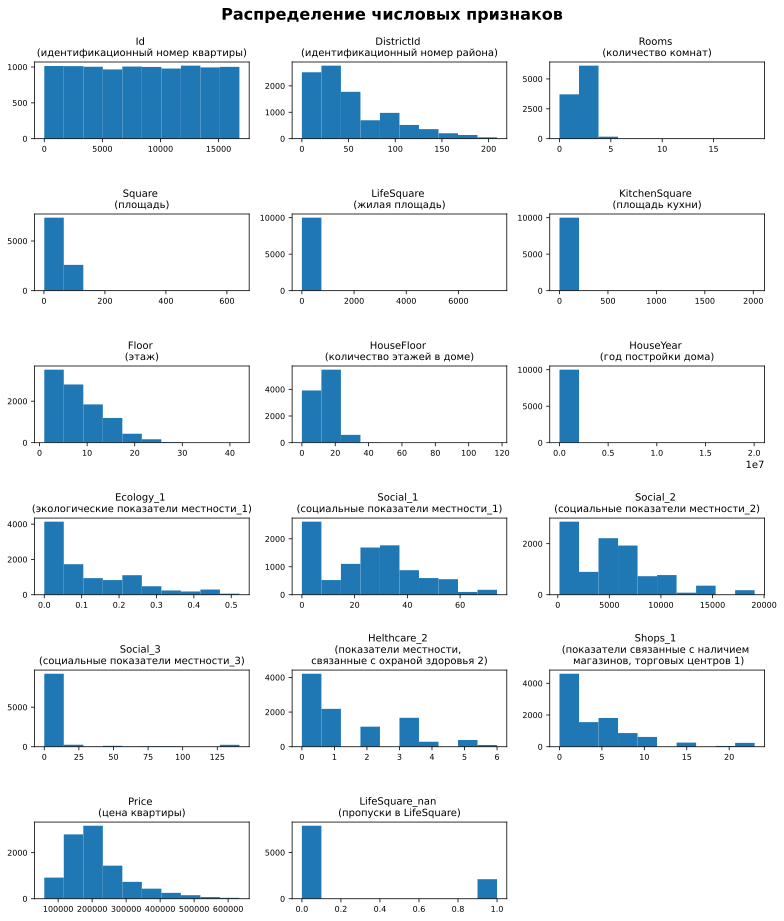

In [309]:
visual_num_feature(train_data, translate)

In [310]:
def visual_str_feature(data, captions):
    plt.figure(figsize=[11, 5])

    plt.suptitle(f'Распределение строковых признаков', 
                    fontsize=16, 
                    fontweight='bold')
    
    for i, col in enumerate(str_cols):
        plt.subplot(2, 3, i+1)
        plt.title(f'\n{col} \n({captions[col]})', fontsize=10)

        plt.hist(data[col], bins=2)
    plt.tight_layout()

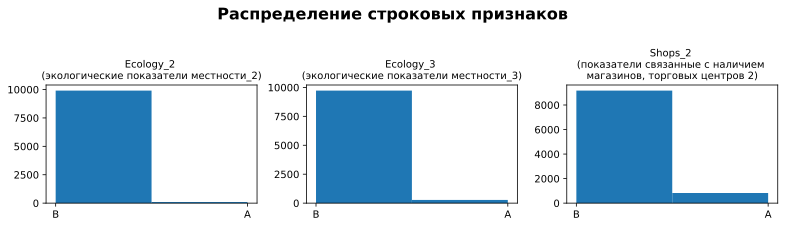

In [311]:
visual_str_feature(train_data, translate)

In [312]:
# sns.boxplot(train_data['LifeSquare']) - выбросы 

## Выбросы

### Исследуем столбец 'Rooms' - количество комнат

In [313]:
# проверим уникальные значения
train_data['Rooms'].unique()

array([ 2.,  3.,  1.,  4., 10.,  0.,  5., 19.,  6.], dtype=float32)

In [314]:
# и количество значений
train_data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Вывод: пока очевидно можно сказать, что наблюдаются выбросы по значениям 5, 0, 10, 19, 6

<Axes: ylabel='Rooms'>

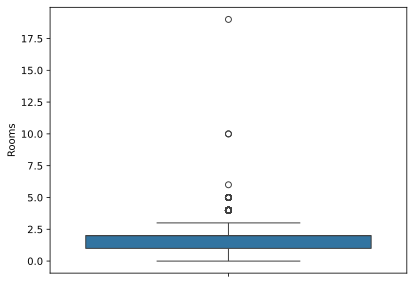

In [315]:
# чтобы убедиться в этом построим ящик с усами
sns.boxplot(train_data['Rooms'])

Вывод:  на графике видно, явный выбросы больше 5 и значения 4 тоже лежат выше квантиля

In [316]:
# посмотрим есть ли квартиры с 5 комнатами и площадью больше 100 - такие квартиры реально могут существовать
train_data[(train_data['Rooms'] == 5) & (train_data['Square'] > 100)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
1503,1243,86,5.0,108.057396,82.723824,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,3,7,B,310305.06250,0
1982,5548,86,5.0,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,3,7,B,455264.87500,0
3268,8901,34,5.0,121.577423,114.913841,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,1,11,B,455446.40625,0
4487,13434,13,5.0,183.382278,100.985504,15.0,2,6.0,1997,0.090799,B,B,74,19083,2,5,15,B,622888.81250,0
4762,4070,21,5.0,114.313751,88.492653,9.0,6,5.0,1960,0.034331,B,B,25,5487,3,0,4,B,499830.93750,0
5361,2879,78,5.0,118.871948,69.023506,10.0,15,16.0,1998,0.092291,B,B,21,4346,2,1,2,B,496026.65625,0
5466,3454,8,5.0,112.135521,79.795448,10.0,4,17.0,1999,0.437885,B,B,23,5735,3,0,5,B,471833.78125,0
6623,3294,167,5.0,111.045799,81.940460,9.0,6,6.0,1940,0.050272,B,B,21,4231,14,0,3,B,513239.50000,0
6988,8685,62,5.0,124.933289,81.122368,30.0,5,3.0,2017,0.072158,B,B,2,629,1,0,0,A,271919.87500,0
8511,4249,23,5.0,198.930176,123.139862,10.0,1,2.0,2011,0.014073,B,B,2,475,0,0,0,B,345665.21875,0


Вывод: Да, такие квартиры есть. Тогда за выброс будем считать квартиры меньше 1 комнаты  и больше 5 комнат и площадью меньше 100. Заменим такие значения на медиану

In [317]:
train_data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [318]:
index_rooms = train_data.query('(Rooms < 1) | ((Rooms >= 5) & (Square < 100))').index
index_rooms

Int64Index([ 377, 1397, 1422, 1454, 1981, 2170, 2269, 3271, 3911, 4366, 4431,
            4853, 6149, 8726, 8834, 8849, 8925],
           dtype='int64')

In [319]:
train_data.loc[index_rooms, ['Rooms']] = train_data['Rooms'].median()

In [320]:
train_data['Rooms'].describe()

count    10000.000000
mean         1.886900
std          0.808068
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

Вывод: после удаления выбросов статистика почти не поменялась: среднее уменьшилось на 0,01, std - на 0,03

### Исследуем столбцы 'Square', 'LifeSquare', 'KitchenSquare' - все, что связано с площадью

In [321]:
SquareList = ['Square', 'LifeSquare', 'KitchenSquare']

In [322]:
# посмотри что из себя представляют данные
train_data[SquareList].sample(10)

,Square,LifeSquare,KitchenSquare
7128,75.012848,75.664299,1.0
3077,37.883575,27.570677,4.0
551,48.128113,45.023533,48.0
235,42.423080,28.087484,5.0
7642,39.918026,23.728638,9.0
6397,58.320377,35.028786,9.0
1334,61.902111,32.781261,1.0
6827,47.024773,34.692070,5.0
3678,46.838161,24.408928,8.0
8430,55.461868,42.326019,5.0


Вывод: Общая и Жилая площадь представляет число с 6 знаками после запятой, такое врядли встречается в реальной жизни. Округлим эти число по 1 знака после запятой

In [323]:
train_data['Square'] = train_data['Square'].apply(lambda x: np.round(x, 1))
train_data['LifeSquare'] = train_data['LifeSquare'].apply(lambda x: np.round(x, 1))

In [324]:
train_data[SquareList].head(5)

,Square,LifeSquare,KitchenSquare
0,48.0,29.4,6.0
1,65.7,40.0,8.0
2,44.9,29.2,0.0
3,53.4,52.7,9.0
4,39.6,23.8,7.0


In [325]:
# посмотрим статистику по выбранным столбцам
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.315610,36.269760,6.273300
std,21.058224,76.609871,28.560917
min,1.100000,0.400000,0.000000
25%,41.800000,25.500000,1.000000
50%,52.500000,32.800000,6.000000
75%,65.900000,41.400000,9.000000
max,641.100000,7480.600000,2014.000000


Вывод: Видим аномально большие максимальные значения всех столбцов

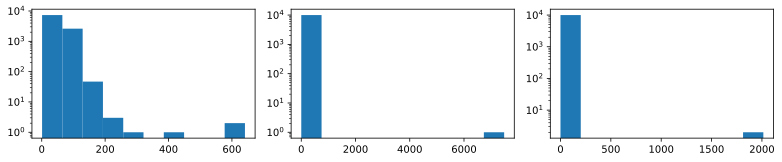

In [326]:
# убедимся в этом, построив гистограммы и применив к ним логарифическую функцию
plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)

plt.tight_layout()

Вывод: Большие значения подтверждаются

In [327]:
# заменим аномально большие значение и значения меньше 5 на медиану
train_data.loc[((train_data['Square'] > 400) | (train_data['Square'] < 5)), ['Square']] = train_data['Square'].median()
train_data.loc[(train_data['LifeSquare'] > train_data['Square'].max()), ['LifeSquare']] = train_data['LifeSquare'].median()
train_data.loc[(train_data['KitchenSquare'] > train_data['Square'].max()), ['KitchenSquare']] = train_data['KitchenSquare'].median()

In [328]:
# заменим все значения площади кухни больше 30 на медиану
train_data.loc[(train_data['KitchenSquare'] >= 30), ['KitchenSquare']] = train_data['KitchenSquare'].median()

Так же должны соблюдаться следующие условия:

* Общая площадь > Жилой площади (это очевидно)
* Общая площадь > Площади кухни (аналогично)
* Общая площадь > Жилая площадь + Площадь кухни 
* Площадь кухни >= Общая площадь - Жилая площадь (еще есть коридор, туалет и балкон)

In [329]:
# Если общая площадь меньше жилой, то ее значение меняем на LifeSquare = KitchenSquare
train_data.loc[(train_data['Square'] <= train_data['LifeSquare']), ['Square']] = train_data['LifeSquare'] + train_data['KitchenSquare']

In [330]:
# Если жилая площадь меньше кухни, то заменим ее на Square - KitchenSquare
train_data.loc[(train_data['LifeSquare'] <= train_data['KitchenSquare']), ['LifeSquare']] = train_data['Square'] - train_data['KitchenSquare']

In [331]:
train_data.loc[(train_data['Square'] < (train_data['LifeSquare'] + train_data['KitchenSquare']))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
3,5809,58,2.0,53.4,52.7,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,0,5,B,175616.234375,0
48,7596,23,1.0,47.1,46.8,12.0,3,9.0,1977,0.014073,B,B,2,475,0,0,0,B,96029.164062,0
69,6925,27,2.0,64.9,63.3,10.0,15,17.0,2016,0.072158,B,B,2,629,1,0,0,A,228584.000000,0
129,6072,6,1.0,65.1,64.6,1.0,10,9.0,2015,0.243205,B,B,5,1564,0,0,0,B,175899.984375,0
136,6172,27,2.0,92.4,92.1,10.0,2,5.0,1977,0.075424,B,B,11,3097,0,0,0,B,116942.671875,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9860,15304,124,1.0,45.2,44.2,13.0,12,12.0,1974,0.122090,B,B,29,6566,7,4,0,B,180351.781250,0
9874,10318,6,1.0,40.6,38.8,7.0,5,17.0,2013,0.243205,B,B,5,1564,0,0,0,B,131271.921875,0
9897,4497,1,1.0,38.3,38.0,8.0,7,17.0,1991,0.025609,B,B,33,5261,0,3,1,B,97464.328125,0
9918,14904,34,4.0,104.0,99.8,10.0,8,25.0,2018,0.069753,B,B,53,13670,4,1,11,B,411971.093750,0


In [332]:
train_data.loc[(train_data['KitchenSquare'] > (train_data['Square'] - train_data['LifeSquare'])), ['KitchenSquare']] = train_data['Square'] - train_data['LifeSquare']

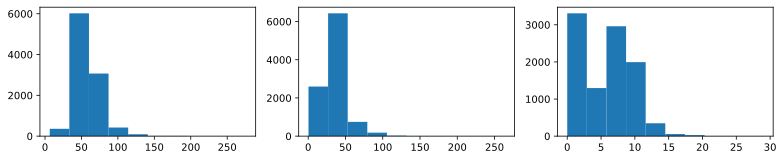

In [333]:

plt.figure(figsize=[11, 13])

for i, col in enumerate(SquareList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col])

plt.tight_layout()

In [334]:
train_data[SquareList].describe()

,Square,LifeSquare,KitchenSquare
count,10000.000000,10000.000000,10000.000000
mean,56.496300,35.416140,5.519431
std,19.302734,16.029432,3.900508
min,6.500000,0.400000,0.000000
25%,42.000000,25.600000,1.000000
50%,52.700000,32.800000,6.000000
75%,66.100000,41.400000,8.000000
max,275.600000,263.500000,29.000000


Вывод: после всех манипуляций с данными столбцами основные статистические данные сильно не изменились (кроме стандартного отклонения, но это из-за изменения максимальных значений)

##### Исследуем столбцы 'Floor' и 'HouseFloor

In [335]:
FloorList = ['Floor', 'HouseFloor']

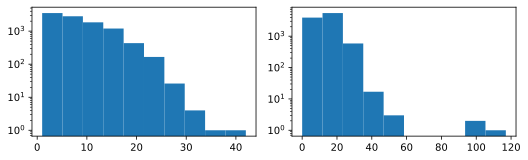

In [336]:
plt.figure(figsize=[11, 13])

for i, col in enumerate(FloorList):
    plt.subplot(6, 3, i+1)
    plt.hist(train_data[col], log=True)

plt.tight_layout()

In [337]:
# посомтрим уникальные значения в обоих столбцах
for el in FloorList:
    print(train_data[el].unique())

[ 7  8 11  5  3 14  9 13  1  6  4 16 12 15 19  2 17 20 10 18 26 23 22 24
 21 25 32 28 27 42 31 37 33]
[  9.  12.  17.   5.   0.   8.   4.  14.  25.   1.  22.  16.  15.   3.
  10.  11.   7.  24.  28.  19.  20.  18.  23.   2.  32.  40.  27.  21.
  13.  45.  30.   6.  37.  48.  47.  44.  39.  36.  29.  99.  38. 117.
  26.  31.]


Вывод: В столбще этажности дома вознимает сомнение значения больше 50 и меньше 1 этажей

In [338]:
train_data.loc[((train_data['HouseFloor'] > 50) | (train_data['HouseFloor'] < 1)), 'HouseFloor'] = train_data['HouseFloor'].median()

In [339]:
# также стоит проверить значения, где указанный этаж больше количества этажей в доме
index_floor = train_data.loc[(train_data['Floor'] > train_data['HouseFloor']), 'HouseFloor'].index
index_floor

Int64Index([   7,   14,   16,   21,   26,   35,   39,   44,   51,   67,
            ...
            9959, 9962, 9971, 9973, 9975, 9984, 9985, 9989, 9991, 9995],
           dtype='int64', length=1610)

In [340]:
train_data[(train_data['Floor'] > train_data['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
7,11993,74,2.0,80.3,32.8,0.0,14,13.0,1977,0.075779,B,B,6,1437,3,0,2,B,221244.156250,1
14,10953,27,1.0,53.8,52.4,1.0,5,4.0,1977,0.072158,B,B,2,629,1,0,0,A,140647.562500,0
16,2119,27,2.0,49.4,32.0,5.0,6,5.0,1983,0.051815,B,B,5,1227,0,0,0,B,117000.382812,0
21,11935,27,2.0,64.7,32.8,1.0,15,1.0,1977,0.211401,B,B,9,1892,0,0,1,B,127200.023438,1
26,4378,27,3.0,107.0,0.6,0.0,17,13.0,2018,0.072158,B,B,2,629,1,0,0,A,337299.875000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.1,47.6,6.0,11,9.0,1983,0.371149,B,B,34,7065,1,2,5,B,226434.875000,0
9985,16159,27,1.0,39.0,32.8,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,0,1,B,95529.570312,1
9989,4145,96,3.0,90.1,47.9,11.0,26,24.0,2005,0.041116,B,B,53,14892,4,1,4,B,441108.906250,0
9991,11553,3,3.0,101.6,51.6,12.0,18,17.0,2000,0.265089,B,B,37,5288,0,3,2,B,212883.500000,0


In [341]:
# заменим это значение на случайное число
train_data.loc[index_floor, 'Floor'] = train_data.loc[index_floor, 'HouseFloor'].apply(lambda x: np.random.randint(1, x+1))

In [342]:
train_data[(train_data['Floor'] > train_data['HouseFloor'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan


##### Исследуем признак 'HouseYear' - год постройки дома

In [352]:
# Посмотрим даты, которые больше текущей даты 
train_data[train_data['HouseYear'] > datetime.now().year]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,LifeSquare_nan
1497,10814,109,1.0,37.3,20.2,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,3,6,B,254084.531250,0
4189,11607,147,2.0,44.8,28.4,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,5,8,B,243028.609375,0


In [353]:
# поменяем аномальные значения на моду (часто встречаемое)
train_data.loc[train_data['HouseYear'] > datetime.now().year, 'HouseYear'] = train_data['HouseYear'].mode()[0]

In [ ]:
plt.hist(train_data['HouseYear'], log=True)
plt.show()